In [6]:
#first we do some imports and check the version of Py-ART for consistency
import pyart
from matplotlib import pyplot as plt
import netCDF4
import numpy as np
import copy
import scipy
from matplotlib import rc

from boto.s3.connection import S3Connection
import gzip
import shutil, os
from datetime import timedelta, datetime
import tempfile

%matplotlib inline
print(pyart._debug_info())

Py-ART version: 1.7.0.dev+d68f30b

---- Dependencies ----
Python version: 2.7.11
NumPy version: 1.10.2
SciPy version: 0.16.0
matplotlib version: 1.4.3
netCDF4 version: 1.2.2

---- Optional dependencies ----
TRMM RSL version: MISSING
CyLP: Available
PyGLPK version: MISSING
CVXOPT version: MISSING
basemap version: 1.0.7
nose version: 1.3.4
None


In [7]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [9]:
fmt = '%Y-%m-%d_%H%M%S' 
radar0 = get_radar_from_aws('KLOT', 
                           datetime.strptime('2013-04-17_200353', fmt))
radar1 = get_radar_from_aws('KLOT', 
                           datetime.strptime('2013-04-17_200810', fmt))
radar2 = get_radar_from_aws('KLOT', 
                           datetime.strptime('2013-04-17_201226', fmt))
radar3 = get_radar_from_aws('KLOT', 
                            datetime.strptime('2013-04-17_201642', fmt))
radar4 = get_radar_from_aws('KLOT', 
                            datetime.strptime('2013-04-17_202058', fmt))
radar5 = get_radar_from_aws('KLOT', 
                            datetime.strptime('2013-04-17_202515', fmt))
radar6 = get_radar_from_aws('KLOT', 
                            datetime.strptime('2013-04-17_202932', fmt))


ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python2.7/site-packages/boto/utils.py", line 210, in retry_url
    r = opener.open(req, timeout=timeout)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 431, in open
    response = self._open(req, data)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 449, in _open
    '_open', req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 409, in _call_chain
    result = func(*args)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1227, in http_open
    return self.do_open(httplib.HTTPConnection, req)
  File "/Users/scollis/anaconda/lib/python2.7/urllib2.py", line 1197, in do_open
    raise URLError(err)
URLError: <urlopen error timed out>
ERROR:boto:Unable to read instance data, giving up
ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda/lib/python

In [11]:
def append_and_grid(radar):
        rain_z = radar.fields['reflectivity']['data'].copy()
        z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
        rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
        radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
        radar.fields['rain_z']['units'] = 'mm/h'
        radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
        radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
        radar.fields['rain_z']['valid_min'] = 0
        radar.fields['rain_z']['valid_max'] = 500
        grid = pyart.map.grid_from_radars(
             (radar,), grid_shape=(1, 801, 801),
            grid_limits=((0, 0),(-80000, 80000), (-80000, 80000)),
            fields=radar.fields.keys(), gridding_algo="map_gates_to_grid",
            weighting_function='BARNES')
        return grid


In [12]:
grid0 = append_and_grid(radar0)
grid1 = append_and_grid(radar1)
grid2 = append_and_grid(radar2)
grid3 = append_and_grid(radar3)
grid4 = append_and_grid(radar4)
grid5 = append_and_grid(radar5)
grid6 = append_and_grid(radar6)


In [13]:
print(  pyart.retrieve.grid_displacement_pc(grid0, grid1, 'rain_z', 0))
print(  pyart.retrieve.grid_displacement_pc(grid1, grid2, 'rain_z', 0))
print(  pyart.retrieve.grid_displacement_pc(grid2, grid3, 'rain_z', 0))
print(  pyart.retrieve.grid_displacement_pc(grid3, grid4, 'rain_z', 0))
print(  pyart.retrieve.grid_displacement_pc(grid4, grid5, 'rain_z', 0))
print(  pyart.retrieve.grid_displacement_pc(grid5, grid6, 'rain_z', 0))


(26, 20)
(27, 20)
(26, 19)
(26, 20)
(26, 19)
(25, 19)


In [14]:
igrid1 = pyart.retrieve.grid_shift(grid1, [0.0, 0.0], trim_edges = 30)
igrid0 = pyart.retrieve.grid_shift(grid0, 
                                   pyart.retrieve.grid_displacement_pc(grid0, grid1, 'rain_z', 0), 
                                   trim_edges = 30)
print(pyart.retrieve.grid_displacement_pc(grid0, grid1, 'rain_z', 0))

(26, 20)


/Users/scollis/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/scollis/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/scollis/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


<matplotlib.contour.QuadContourSet instance at 0x10bf2d170>

/Users/scollis/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


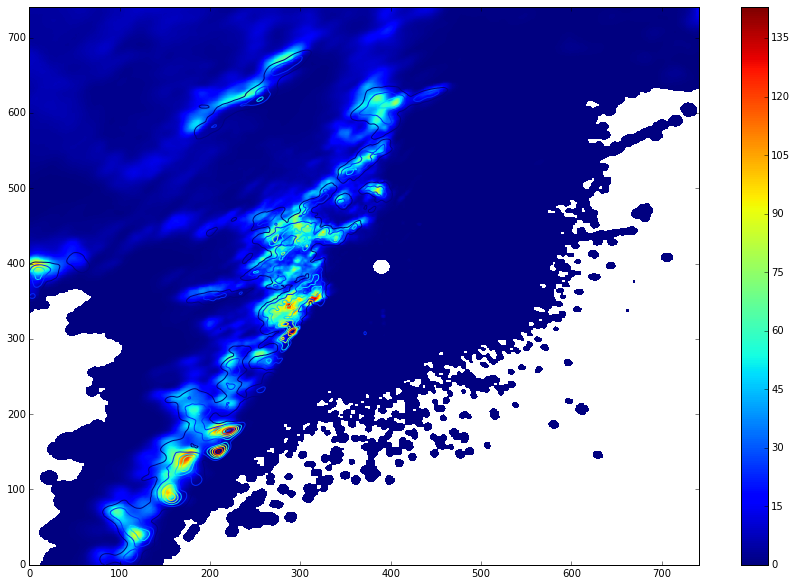

In [15]:
fig = plt.figure(figsize = [15,10])
plt.pcolormesh(igrid0.fields['rain_z']['data'][0,:,:])
ax = plt.gca()
plt.colorbar()
ax.contour(igrid1.fields['rain_z']['data'][0,:,:])
